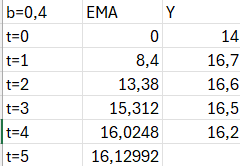

In [1]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.FashionMNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download = True, train = False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

X_train = X_train.float()
X_test = X_test.float()

X_train.shape, X_test.shape

100%|██████████| 26421880/26421880 [00:01<00:00, 14631795.80it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 309672.24it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1061370.17it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11050295.29it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

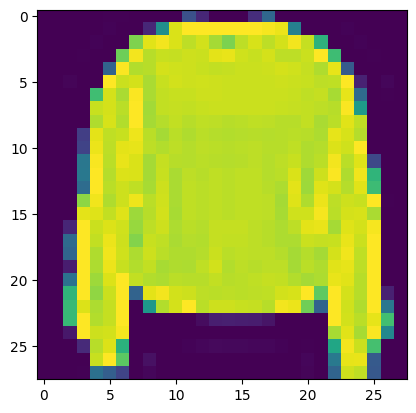

tensor(2)


In [3]:
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [4]:
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [5]:
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    #Ваш_Код_Здесь

    self.fc1 = th.nn.Linear(784, 128)
    self.act1 = th.nn.ReLU()
    self.drop = th.nn.Dropout(p=0.25)
    self.fc2 = th.nn.Linear(128,64)
    self.act2 = th.nn.ReLU()
    self.fc3 = th.nn.Linear(64,10)
    self.sm = th.nn.Softmax(dim=1)


  def forward(self, x):
    #Ваш_Код_Здесь

    x = self.fc1(x)
    x = self.act1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x=self.sm(x)
    return x


  def predict(self,x):
    #Ваш_Код_Здесь
    x=self.forward(x)
    print(x)
    x=self.sm(x)
    return x

net = MNISTnet()

In [6]:
loss = th.nn.CrossEntropyLoss()

#Momentum

In [7]:
opt = th.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [8]:
batch_size = 784 # размер батча
epochs = 25 #количество эпох

train_losses = []
test_losses = []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in range(epochs):
  test_preds = net.forward(X_test)
  test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    #Ваш_Код_Здесь
    #далее вырезаем куски датасета длинной batch_size
    opt.zero_grad()

    batch_index = order[start_index:start_index+batch_size]#из этого порядка вычисляем некоторые подмножества
    #начиная с start_index, который будет 0, 10, 20 и тд. + batch_size
    #то есть batch_index - это индексы, которые соотвествуют текущему батчу
    #таким образом мы в эпохе проходим все значения в датасете, но итерация обучения происходит по 10 элементам

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    if start_index==0:
      train_losses.append(loss_val.cpu().detach().numpy())
    loss_val.backward()

    opt.step()


  #test_preds = net.forward(X_test)
  #test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  if epoch % 10 == 0:
    test_preds = net.forward(X_test)
    test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())
    test_preds = test_preds.argmax(dim=1)
    print((test_preds == y_test).float().mean())

tensor(0.4540)
tensor(0.6462)
tensor(0.7409)


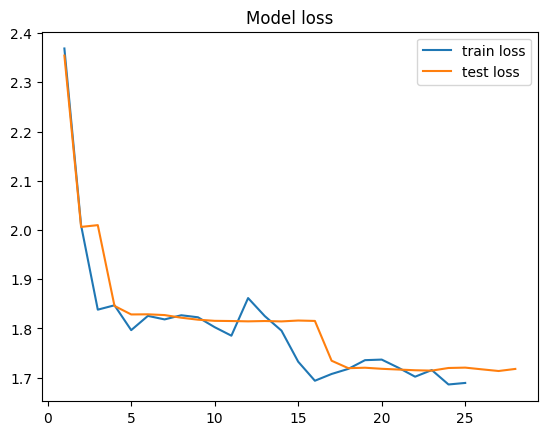

In [9]:
train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
x1 = np.arange(1, len(train_losses) + 1)
x2 = np.arange(1, len(test_losses) + 1)

plt.plot(x1, train_losses, label='train loss')
plt.plot(x2, test_losses, label='test loss')
plt.title('Model loss')
plt.legend()
plt.show()

In [10]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 14.1 MB/s eta 0:00:00


In [11]:
from torchmetrics.classification import F1Score

f1 = F1Score(task="multiclass", num_classes=10)
f1(preds, y_test)

RuntimeError: The size of tensor a (416) must match the size of tensor b (10000) at non-singleton dimension 0

#AdaGrad

In [12]:
opt = th.optim.Adam(net.parameters(), lr=0.001)

In [13]:
batch_size = 64 # размер батча
epochs = 40 #количество эпох

train_losses = []
test_losses = []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in range(epochs):
  test_preds = net.forward(X_test)
  test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    #Ваш_Код_Здесь
    #далее вырезаем куски датасета длинной batch_size
    opt.zero_grad()

    batch_index = order[start_index:start_index+batch_size]#из этого порядка вычисляем некоторые подмножества
    #начиная с start_index, который будет 0, 10, 20 и тд. + batch_size
    #то есть batch_index - это индексы, которые соотвествуют текущему батчу
    #таким образом мы в эпохе проходим все значения в датасете, но итерация обучения происходит по 10 элементам

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    if start_index==0:
      train_losses.append(loss_val.cpu().detach().numpy())
    loss_val.backward()

    opt.step()


  #test_preds = net.forward(X_test)
  #test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  if epoch % 10 == 0:
    test_preds = net.forward(X_test)
    test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())
    test_preds = test_preds.argmax(dim=1)
    print((test_preds == y_test).float().mean())

tensor(0.6285)
tensor(0.5519)
tensor(0.6692)
tensor(0.6156)


#RMSProp

In [14]:
opt = th.optim.Adam(net.parameters(), lr=0.001)

In [15]:
batch_size = 64 # размер батча
epochs = 10 #количество эпох

train_losses = []
test_losses = []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in range(epochs):
  test_preds = net.forward(X_test)
  test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    #Ваш_Код_Здесь
    #далее вырезаем куски датасета длинной batch_size
    opt.zero_grad()

    batch_index = order[start_index:start_index+batch_size]#из этого порядка вычисляем некоторые подмножества
    #начиная с start_index, который будет 0, 10, 20 и тд. + batch_size
    #то есть batch_index - это индексы, которые соотвествуют текущему батчу
    #таким образом мы в эпохе проходим все значения в датасете, но итерация обучения происходит по 10 элементам

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    if start_index==0:
      train_losses.append(loss_val.cpu().detach().numpy())
    loss_val.backward()

    opt.step()


  #test_preds = net.forward(X_test)
  #test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  if epoch % 10 == 0:
    test_preds = net.forward(X_test)
    test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())
    test_preds = test_preds.argmax(dim=1)
    print((test_preds == y_test).float().mean())

tensor(0.6881)


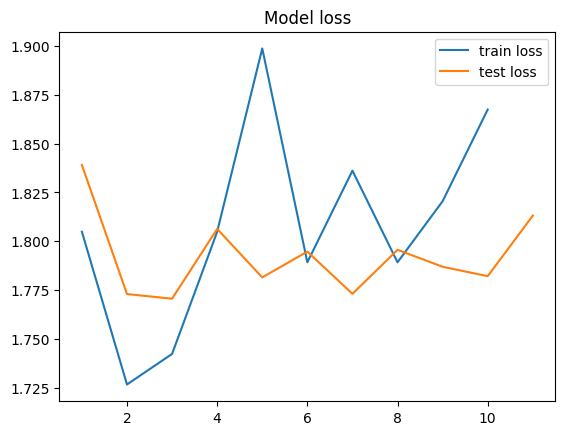

In [16]:
train_losses = [float(i) for i in train_losses]
test_losses = [float(i) for i in test_losses]
x1 = np.arange(1, len(train_losses) + 1)
x2 = np.arange(1, len(test_losses) + 1)

plt.plot(x1, train_losses, label='train loss')
plt.plot(x2, test_losses, label='test loss')
plt.title('Model loss')
plt.legend()
plt.show()

#Adam

In [17]:
opt = th.optim.Adam(net.parameters(), lr=0.001)

In [18]:
batch_size = 64 # размер батча
epochs = 40 #количество эпох

train_losses = []
test_losses = []

'''данные тренировочной выборки будем перекладывать на cuda по батчам'''
for epoch in range(epochs):
  test_preds = net.forward(X_test)
  test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    #Ваш_Код_Здесь
    #далее вырезаем куски датасета длинной batch_size
    opt.zero_grad()

    batch_index = order[start_index:start_index+batch_size]#из этого порядка вычисляем некоторые подмножества
    #начиная с start_index, который будет 0, 10, 20 и тд. + batch_size
    #то есть batch_index - это индексы, которые соотвествуют текущему батчу
    #таким образом мы в эпохе проходим все значения в датасете, но итерация обучения происходит по 10 элементам

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]

    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    if start_index==0:
      train_losses.append(loss_val.cpu().detach().numpy())
    loss_val.backward()

    opt.step()


  #test_preds = net.forward(X_test)
  #test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())

  if epoch % 10 == 0:
    test_preds = net.forward(X_test)
    test_losses.append(loss(test_preds, y_test).cpu().detach().numpy())
    test_preds = test_preds.argmax(dim=1)
    print((test_preds == y_test).float().mean())

tensor(0.6401)
tensor(0.6682)
tensor(0.6878)
tensor(0.6709)
